In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

2024-02-25 09:25:25.459795: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 09:25:25.459900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 09:25:25.582993: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# DATASET

In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_data(directory, target_size=(256, 256)):
    images = []
    masks = []
    count = 1
    for folder_name in sorted(os.listdir(directory)):
        if count == 5:
            break
        folder_path = os.path.join(directory, folder_name)
        if os.path.isdir(folder_path):
            image_folder = os.path.join(folder_path, 'image')
            mask_folder = os.path.join(folder_path, 'mask')
            # Get sorted list of file names
            image_files = sorted(os.listdir(image_folder))
            mask_files = sorted(os.listdir(mask_folder))
            for image_file, mask_file in zip(image_files, mask_files):
                image_path = os.path.join(image_folder, image_file)
                mask_path = os.path.join(mask_folder, mask_file)
                if os.path.isfile(image_path) and os.path.isfile(mask_path):
                    image = load_img(image_path, target_size=target_size)
                    mask = load_img(mask_path, target_size=target_size, color_mode='grayscale')
                    images.append(img_to_array(image) / 255.0)
                    masks.append(img_to_array(mask) / 255.0)
        count += 1
    return np.array(images), np.array(masks)

In [3]:
train_dir = '/kaggle/input/ct-heart-segmentation/data/train'

X_train, y_train = load_data(train_dir)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (523, 256, 256, 3)
y_train shape: (523, 256, 256, 1)


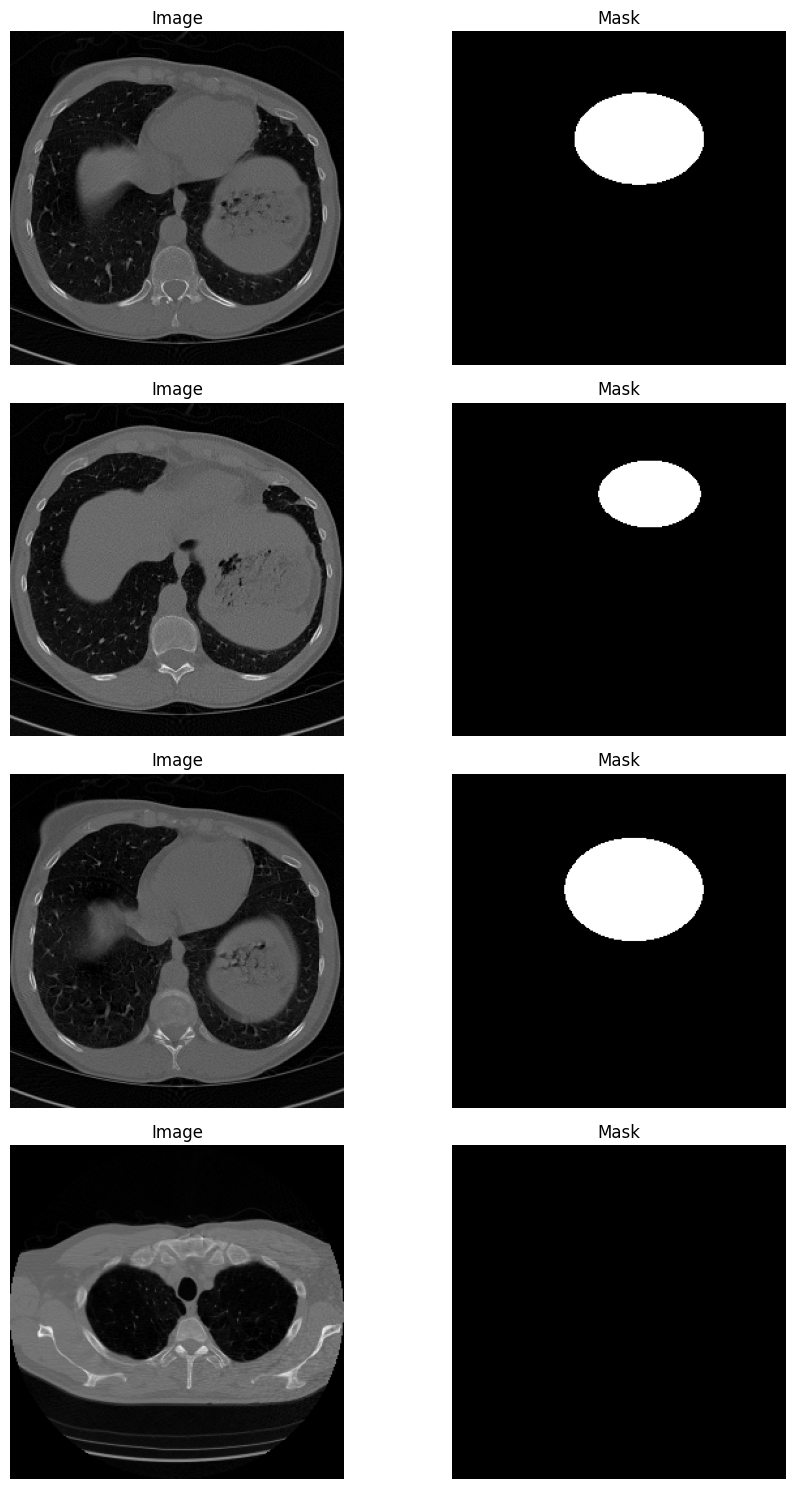

In [4]:
import matplotlib.pyplot as plt
import random

def visualize_random_samples(images, masks, num_samples=4):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 15))
    random_indices = random.sample(range(len(images)), num_samples)
    for i, idx in enumerate(random_indices):
        axes[i, 0].imshow(images[idx])
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(masks[idx][:, :, 0], cmap='gray')
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

visualize_random_samples(X_train, y_train)

# Model

In [5]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [6]:
from tensorflow.keras.metrics import Recall, Precision

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [7]:
H = 256
W = 256
lr = 1e-4

model = build_unet((H, W, 3))
metrics = [dice_coef, iou, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)

## CPU Optimization

In [10]:
config = tf.compat.v1.ConfigProto()
config.intra_op_parallelism_threads = 4  # Adjust according to your CPU cores
config.inter_op_parallelism_threads = 4
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

X_train_tf = tf.convert_to_tensor(X_train)
y_train_tf = tf.convert_to_tensor(y_train)

dataset = tf.data.Dataset.from_tensor_slices((X_train_tf, y_train_tf))

batch_size = 32
dataset = dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)

train_size = int(0.8 * len(X_train))
train_dataset = dataset.take(train_size)
validation_dataset = dataset.skip(train_size)

# Training

In [ ]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard, EarlyStopping

model_path = 'model/weights.h5'
csv_path = 'training/logs.csv'

os.makedirs(os.path.dirname(model_path), exist_ok=True)
os.makedirs(os.path.dirname(csv_path), exist_ok=True)

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False),
]

model.fit(
    dataset,
    epochs=10,
    callbacks=callbacks,
    shuffle=False
)

Epoch 1/10
17/17 [==============================] - 1123s 65s/step - loss: 0.8809 - dice_coef: 0.1200 - iou: 0.0643 - recall: 0.8112 - precision: 0.0836 - lr: 1.0000e-04
Epoch 2/10
17/17 [==============================] - 1114s 65s/step - loss: 0.7952 - dice_coef: 0.2044 - iou: 0.1149 - recall: 0.9086 - precision: 0.1865 - lr: 1.0000e-04
Epoch 3/10
17/17 [==============================] - 1114s 65s/step - loss: 0.6719 - dice_coef: 0.3346 - iou: 0.2031 - recall: 0.9459 - precision: 0.4347 - lr: 1.0000e-04
Epoch 4/10
17/17 [==============================] - 1113s 65s/step - loss: 0.5640 - dice_coef: 0.4330 - iou: 0.2793 - recall: 0.9570 - precision: 0.6764 - lr: 1.0000e-04
Epoch 5/10
12/17 [====================>.........] - ETA: 5:40 - loss: 0.5276 - dice_coef: 0.4724 - iou: 0.3125 - recall: 0.9489 - precision: 0.7599

In [ ]:
model.save('model/model.h5')

# Testing

In [ ]:
from glob import glob
X_test= glob("data/test/*/*/*.dcm")

In [ ]:
num_samples_to_test = 10
test_indices = random.sample(range(len(test_x)), num_samples_to_test)

for index in test_indices:
    x = test_x[index]

    """ Extract the names """
    dir_name = x.split("/")[-3]
    name = dir_name + "_" + x.split("/")[-1].split(".")[0]

    """ Read the image """
    image = dicom.dcmread(x).pixel_array
    image = np.expand_dims(image, axis=-1)
    image = image/np.max(image) * 255.0
    x = image/255.0
    x = np.concatenate([x, x, x], axis=-1)
    x = np.expand_dims(x, axis=0)

    """ Prediction """
    mask = model.predict(x)[0]
    mask = mask > 0.5
    mask = mask.astype(np.int32)
    mask = mask * 255

    """ Display """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image.squeeze(), cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(mask.squeeze(), cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')
    plt.show()